# Deep Reinforcement Learning - Portfolio Management Problem

In this notebook we implement the problem and methodology described in a previous report. It concerns a Portfolio Management Problem in context of the UZH Deep Reinforcement Learning Course for Team Drunken Policy.

This Deep Policy Network Reinforcement Learning project is our implementation and further research of the original paper A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem (Jiang et al. 2017) (https://arxiv.org/pdf/1706.10059.pdf). It is partly inspired by their public repository https://github.com/ZhengyaoJiang/PGPortfolio, however almost all of the implementation below is by us done from scratch.

The problem deals with an automated portfolio management. Given a set of stocks, how to best allocate money through time to maximize returns at the end of a certain number of timesteps. We have built an automated agent which best allocates the weights of its investment between different stocks.


We implemented the problem on theirs half-hour cryptocurrency data and extend the experiment to the stock market, using the framework on daily data and intraday minute data with a daily rebalance.


### Imports and requirements


In [0]:
import os
import random
import math
import numpy as np
import pandas as pd
from tqdm import tqdm

%tensorflow_version 1.x
import tensorflow as tf

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### Parameters Setup

Here we define all the parameters that can be easily varied in our project.

There are Financial parameters, such as initial portfolio capital for the training and testing period. An estimate of trading_cost from which is then calculated our transaction factor.

Next there are Training parameters which influence the training of the agent. For example a batch size which is window of such width which is sequentially feeded into the neural network to train. Tensor history governs how much is the neural net allowed to look for history of prices of assets. Number of episodes and batches in the training phase. Train-validation ratios and an exploration/exploitation fraction.

Lastly there are also parameters governing the architecture of the network such as kernel sizes and number of filters, or parameters of the optimization problem such as learning rate and optimization algorithm.

In [0]:
#@markdown ####Finance parameters
pf_init_train = 10000 #@param {type: "number"}
pf_init_test = 10000  #@param {type: "number"}
trading_cost = 1e-5 #@param {type: "number"}
interest_rate= 1e-5 #@param {type: "number"} 
cash_bias_init = 0.5
sample_bias = 5e-5 

#@markdown ####Training parameters
batch_size =  100 #@param {type: "number"}                                  # Size of mini-batch during training
tensor_history = 10 #@param {type: "number"}
n_episodes = 3 #@param {type: "number"}
n_batches = 10 #@param {type: "number"}
ratio_train = 0.6
ratio_valid = 0.2                                         
ratio_greedy = 0.8
ratio_regul = 0.1

#@markdown ####Network parameters
n_filter_1 = 2
n_filter_2 = 20
kernel1_size = (1,3)
learning_rate = 1e-3  #@param {type: "number"}      
momentum = 0.9 #@param {type: "number"}  
#optimizer = tf.train.AdamOptimizer(learning_rate)
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)



### Data Preprocessing

Here we create the input tensor from the individual .csv files for different assets. It creates the tensor in numpy format and saves it. Optionally one can work directly with the precomputed input tensor. The precomputed price tensor contains a daily data on 5 stocks (AAPL, AXP, BA, CAT, CSCO).

For each stock, the input is a raw time series of the prices (High, Low, Open, Close). Note that we include both Close from previous period (t-1) and Open from current period (t) as they differe for daily stock market data. (Note, they usually differ in practice also for half-hour or minute data)

The features columns correspond to:
- Close(t-1)/Open(t-1)
- High(t-1)/Open(t-1)
- Low(t-1)/Open(t-1)
- Open(t)/Open(t-1)
    
We don't need to normalize the data since it's already of ratio of prices and hence close to one.

The shape of the precomputed price tensor corresponds to:
- 4: Number of features
- 5: Number of stocks 
- 1259: Number of data points

In [0]:
#@markdown Select which type of data to use
data_dir = 'StocksD' #@param ['StocksD', 'StocksM', 'CryptoH']

#@markdown Create input tensor
uploaded_price_tensor = 'True' #@param ['True', 'False']

# False, input.npy file is uploaded
# True, .csv data of individual stocks are uploaded

In [5]:
if uploaded_price_tensor == 'True':
    path_data = './input.npy'
    data = np.load(path_data)   
    list_stock = ['AAPL', 'AXP', 'BA', 'CAT', 'CSCO'] 
    print('\n Input tensor read and ready to use!')
else:
    directory = os.getcwd() + './Data/' + data_dir + '/'                                  # Specify Directory of Data
    stock_files = os.listdir(directory)                                         # Get list of all files
    stock_files.sort()

    for file in stock_files:                                                    # Remove hidden and unwanted files
        if file[0] == '.': stock_files.remove(file)
        if file[0] == '~': stock_files.remove(file)

    selection = []                                                              # Load only subset of assets
    if selection: stock_files = [stock_files[i] for i in selection ]

    list_stock = [file.split('_')[0] for file in stock_files]                   # Extract stock names only

    kept_stocks = list() 
    not_kept_stocks = list()       

    for s in stock_files:                                                       # Check the history of stocks matches
        df = pd.read_csv(directory + s)
        if data_dir == 'StocksD':   
            input_n = 1259                                                      # Stocks Daily data of 5 years (252*5)
            if len(df)>=input_n: kept_stocks.append(s)
            else: not_kept_stocks.append(s)
        elif data_dir == 'StocksM':
            input_n = 59280                                                     # Stocks Minute data of 1/2 year (152*6.5*60)
            if len(df)>=input_n: kept_stocks.append(s)
            else: not_kept_stocks.append(s)
        elif data_dir == 'CryptoH':
            input_n = 17520                                                     # Crypto Half-hour data of 1 year (365*24*2)
            if len(df)>=input_n: kept_stocks.append(s)
            else: not_kept_stocks.append(s)

    print('\n There is {} different assets. \n Following assets will be loaded {}'.format(len(list_stock),list_stock))
    if not_kept_stocks: print(' Error in reading following stocks {}'.format(not_kept_stocks))

    list_open = list()                                                          # Read following features from data
    list_close = list()
    list_high = list()
    list_low = list()

    for s in tqdm(kept_stocks):                                                     
        data = pd.read_csv(directory + s).fillna('bfill').copy()
        data = data[['open', 'close', 'high', 'low']]
        data = data.tail(input_n)
        list_open.append(data.open.values)
        list_close.append(data.close.values)
        list_high.append(data.high.values)
        list_low.append(data.low.values)

    array_open = np.transpose(np.array(list_open))[:-1]                         # Shift them according to period they belong to
    array_open_of_the_day = np.transpose(np.array(list_open))[1:]
    array_close = np.transpose(np.array(list_close))[:-1]
    array_high = np.transpose(np.array(list_high))[:-1]
    array_low = np.transpose(np.array(list_low))[:-1]  

    X = np.transpose(np.array([array_close/array_open,                          # Combine data together into one tensor
                              array_high/array_open,
                              array_low/array_open,
                              array_open_of_the_day/array_open]), axes= (0,2,1))

    input_f, input_m, input_n = X.shape                                         # Check dimensions of data
    print('\n Data have shape {}'.format(X.shape))
    print(' Number of features: {}'.format(input_f))
    print(' Number of assets: {}'.format(input_m))
    print(' Number of samples: {}'.format(input_n))

    np.save('./input.npy', X)                                                   # Save input tensor
    data = np.load(path_data)                                                   # Read data to be used below
    print('\n Input tensor saved and ready to use!')



 Input tensor read and ready to use!


### Trading Envirionment

The portfolio manager agent is set-up in following way:

The state (at time t) is the input matrix and the previous portfolio weights (at time t-1).
The action is the vector of investment weight (at time t).
The reward function is defined such as it is the agent's return minus a baseline’s return (baseline is an equi weighted agent - invest in all the possible stocks in the same way) minus a transaction factor estimated by the transaction cost and maximum change of weight of asset. (this is specifficaly set-up to make the agent avoids to invest fully in one stock of make large bets)

In [0]:
class TradeEnv():
    """
    This class is the trading environment (render) of our project. 
    The trading agent calls the class by giving an action at the time t. 
    Then the render gives back the new portfolio at the next step (time t+1). 

    # Parameters:
    - windonw_length: number of time inputs looked in the past to build the input tensor
    - portfolio_value: initial value of the portfolio 
    - trading_cost: cost (in % of the traded stocks) the agent will pay to execute the action 
    - interest_rate: rate (in % of the money the agent has) the agent will either get at each step 
                     if he has a positive amount of money or pay if he has a negative amount of money
    -train_size: fraction of data used for the training of the agent, (train -> | time T | -> test)
    """

    def __init__(self, path = './input.npy', window_length=50,
                 portfolio_value= 10000, trading_cost= 0.25/100,
                 interest_rate= 0.02/250, train_size = 0.7):
        
        self.path = path                                                        # path to numpy data
        self.data = np.load(self.path)                                          # load the input tensor
        self.portfolio_value = portfolio_value                                  # initial input value
        self.window_length = window_length                                      # window of previous samples
        self.trading_cost = trading_cost                                        # trading costs
        self.interest_rate = interest_rate                                      # interest rate on money
        self.nb_features = self.data.shape[0]                                   # number of features
        self.nb_stocks = self.data.shape[1]                                     # number of stocks
        self.nb_samples = self.data.shape[2]                                    # number of samples
        self.end_train = int((self.nb_samples-self.window_length)*train_size)   # number of training samples
        self.index = None                                                       # initial index - integer / time step t currently happening
        self.state = None                                                       # initial state - tuple / data, portfolio weights, portfolio value
        self.done = False                                                       # epoch indicator

    def return_pf(self):
        """
        Current portfolio value
        """
        return self.portfolio_value
        
    def readTensor(self,X,t): 
        """                                         
        Input tensor for NN. All features, All stocks, Current time up to window previous values
        """
        return X[ : , :, t-self.window_length:t ]
    
    def readUpdate(self, t):
        """
        Return of each stock for the period t 
        """
        return np.array([1+self.interest_rate]+self.data[-1,:,t].tolist())
    
    def reset(self, w_init, p_init, t=0 ):
        """
        Reset the environments' epoch with given first window of data, initial portfolio weights and value of portfolio
        """
        self.state = (self.readTensor(self.data, self.window_length), w_init , p_init )
        self.index = self.window_length + t
        self.done = False
        return self.state, self.done
  
    def step(self, action):
        """
        Main function of the render. At each step t, the trading agent gives (the action he wants to do) the new value of the weights of the portfolio. 
        The function computes the new value of the portfolio at the step (t+1), it returns also the reward associated with the action the agent took. 
        The reward is defined as the evolution of the the value of the portfolio in %. 
        """
        index = self.index                                                      # current time step
        data = self.readTensor(self.data, index)                                # current input tensor
        done = self.done                                                        # current epoch indicator

        # Beginning of the day / period
        state = self.state                                                      # state space at the beginning of the period
        w_previous = state[1]                                                   # weights of the portfolio at the beginning of the day
        pf_previous = state[2]                                                  # value of portfolio at the beginning of the day        
        update_vector = self.readUpdate(index)                                  # vector of opening price of the period divided by opening price of previous period
        w_alloc = action                                                        # action - chosen weights for portfolio for the next step 
        trans_f = np.linalg.norm((w_alloc-w_previous),ord=1)*self.trading_cost  # transaction remainder factor
        cost = pf_previous * trans_f                                            # compute transaction cost
        v_alloc = pf_previous * w_alloc                                         # convert weight vector into value vector
        v_trans = v_alloc - np.array([cost] + [0]*self.nb_stocks)               # substract the transaction cost from each value vector
        
        # End of the day / period
        v_evol = v_trans*update_vector                                          # compute value evolution of portfolio 
        pf_evol = np.sum(v_evol)                                                # compute the total new portfolio value
        w_evol = v_evol/pf_evol                                                 # compute weight vector of portfolio
        reward = (pf_evol-pf_previous)/pf_previous                              # compute instanteanous reward
        index = index + 1                                                       # update index
        state = (self.readTensor(self.data, index), w_evol, pf_evol)            # compute new state

        if index >= self.end_train: done = True                                 # check if epoch has ended
        self.state = state                                                      # save state
        self.index = index                                                      # save time step
        self.done = done                                                        # save epoch indicato
        
        return state, reward, done
        
      

### Deep Policy Network

The policy function is designed through a convolutional neural network which takes as input the input tensor and outputs are the weights for different assets which corresponds to the actions the agent will take. The first convolution is realized resulting in a smaller tensor. Then, a second convolution expands the number of convolutional filters. The network convolutes each asset independently and at final flattened layers, it incorporates its portfolio weight from previous period by stacking the previous output vector. Lastly, a cash bias is added and a softmax function is applied.

The environment then cmpute the new vector of weights, the new portfolio and instant reward.

In [0]:
class Policy(object):
    '''
    This class is used to instanciate the policy network agent
    '''

    def __init__(self, m, n, sess, optimizer,
                 trading_cost=trading_cost,
                 interest_rate=interest_rate,
                 n_filter_1=n_filter_1,
                 n_filter_2=n_filter_2):

        # parameters
        self.trading_cost = trading_cost
        self.interest_rate = interest_rate
        self.n_filter_1 = n_filter_1
        self.n_filter_2 = n_filter_2
        self.n = n
        self.m = m

        with tf.variable_scope("Inputs"):                                       # Placeholders for variables
            self.X_t = tf.placeholder(
                tf.float32, [None, nb_feature_map, self.m, self.n])             # The Price tensor
            self.W_previous = tf.placeholder(tf.float32, [None, self.m+1])      # weights at the previous time step
            self.pf_value_previous = tf.placeholder(tf.float32, [None, 1])      # portfolio value at the previous time step
            self.dailyReturn_t = tf.placeholder(tf.float32, [None, self.m])     # vector of Open(t+1)/Open(t)
            #self.pf_value_previous_eq = tf.placeholder(tf.float32, [None, 1])

        with tf.variable_scope("Policy_Model"):                                 # Policy function

            bias = tf.get_variable('cash_bias', shape=[1, 1, 1, 1], 
                                   initializer=tf.constant_initializer(cash_bias_init))  # variable of the cash bias
            shape_X_t = tf.shape(self.X_t)[0]                                   # shape of the tensor == batchsize
            self.cash_bias = tf.tile(bias, tf.stack([shape_X_t, 1, 1, 1]))      # modify to get a "tensor size" for the cash bias
            # print(self.cash_bias.shape)

            with tf.variable_scope("Conv1"):                                    # first layer on the X_t tensor, return a tensor of depth 2
                self.conv1 = tf.layers.conv2d(
                    inputs=tf.transpose(self.X_t, perm=[0, 3, 2, 1]),
                    activation=tf.nn.relu,
                    filters=self.n_filter_1,
                    strides=(1, 1),
                    kernel_size=kernel1_size,
                    padding='same')

            with tf.variable_scope("Conv2"):                                    # feature maps
                self.conv2 = tf.layers.conv2d(
                    inputs=self.conv1,
                    activation=tf.nn.relu,
                    filters=self.n_filter_2,
                    strides=(self.n, 1),
                    kernel_size=(1, self.n),
                    padding='same')

            with tf.variable_scope("Tensor3"):                                  # include weights w from last period, modify to have good dimensions
                w_wo_c = self.W_previous[:, 1:]
                w_wo_c = tf.expand_dims(w_wo_c, 1)
                w_wo_c = tf.expand_dims(w_wo_c, -1)
                self.tensor3 = tf.concat([self.conv2, w_wo_c], axis=3)

            with tf.variable_scope("Conv3"):                                    # last feature map WITHOUT cash bias
                self.conv3 = tf.layers.conv2d(
                    inputs=self.conv2,
                    activation=tf.nn.relu,
                    filters=1,
                    strides=(self.n_filter_2 + 1, 1),
                    kernel_size=(1, 1),
                    padding='same')

            with tf.variable_scope("Tensor4"):                                  # last feature map WITH cash bias, squeeze to reduce and get the good dimension
                self.tensor4 = tf.concat([self.cash_bias, self.conv3], axis=2)  
                self.squeezed_tensor4 = tf.squeeze(self.tensor4, [1, 3])       

            with tf.variable_scope("Policy_Output"):                            # softmax layer to obtain weights
                self.action = tf.nn.softmax(self.squeezed_tensor4)              

            with tf.variable_scope("Reward"):                                   # computation of the reward

                constant_return = tf.constant(1+self.interest_rate, shape=[1, 1])
                cash_return = tf.tile(constant_return, tf.stack([shape_X_t, 1]))
                y_t = tf.concat([cash_return, self.dailyReturn_t], axis=1)
                Vprime_t = self.action * self.pf_value_previous
                Vprevious = self.W_previous*self.pf_value_previous

                constant = tf.constant(1.0, shape=[1])                          
                cost = self.trading_cost * tf.norm(Vprime_t-Vprevious, ord=1, axis=1) * constant
                cost = tf.expand_dims(cost, 1)
                zero = tf.constant(np.array([0.0]*m).reshape(1, m), shape=[1, m], dtype=tf.float32)
                vec_zero = tf.tile(zero, tf.stack([shape_X_t, 1]))
                vec_cost = tf.concat([cost, vec_zero], axis=1)

                Vsecond_t = Vprime_t - vec_cost

                V_t = tf.multiply(Vsecond_t, y_t)
                self.portfolioValue = tf.norm(V_t, ord=1)
                self.instantaneous_reward = (self.portfolioValue-self.pf_value_previous)/self.pf_value_previous
                
            with tf.variable_scope("Reward_Equiweighted"):                      # computation of the reward of equiwighted portfolio
                constant_return = tf.constant(1+self.interest_rate, shape=[1, 1])
                cash_return = tf.tile(constant_return, tf.stack([shape_X_t, 1]))
                y_t = tf.concat([cash_return, self.dailyReturn_t], axis=1)
  
                V_eq = w_eq*self.pf_value_previous
                V_eq_second = tf.multiply(V_eq, y_t)
        
                self.portfolioValue_eq = tf.norm(V_eq_second, ord=1)
            
                self.instantaneous_reward_eq = (self.portfolioValue_eq-self.pf_value_previous)/self.pf_value_previous
                
            with tf.variable_scope("Max_weight"):                               # largest change in weight
                self.max_weight = tf.reduce_max(self.action)
                #print(self.max_weight.shape)
                
            with tf.variable_scope("Reward_adjusted"):
                self.adjusted_reward = self.instantaneous_reward - self.instantaneous_reward_eq - ratio_regul * self.max_weight
                
        #objective function
        self.train_op = optimizer.minimize(-self.adjusted_reward)               # maximize reward over the batch, where min(-r) = max(r)
        self.optimizer = optimizer
        self.sess = sess

    def compute_W(self, X_t_, W_previous_):
        """
        This function returns the action the agent takes given the input tensor and the W_previous.
        It is a vector of weights
        """
        return self.sess.run(tf.squeeze(self.action), feed_dict={self.X_t: X_t_, self.W_previous: W_previous_})

    def train(self, X_t_, W_previous_, pf_value_previous_, dailyReturn_t_):
        """
        This function trains the neural network
        maximizing the reward  and the input is a batch of the differents values
        """
        self.sess.run(self.train_op, feed_dict={self.X_t: X_t_,
                                                self.W_previous: W_previous_,
                                                self.pf_value_previous: pf_value_previous_,
                                                self.dailyReturn_t: dailyReturn_t_})

### Portfolio Vector Memory

As mentioned above, we need to input previous portfolio weights to the neural network, therefore we need to create an object that will store the memory of such portfolio vector.

In [0]:
class PVM(object):
    """
    This is the memory stack of weights, called Portfolio Vector Memory
    """
    def __init__(self, m, sample_bias, total_steps, batch_size, w_init):
        
        self.memory = np.transpose(np.array([w_init]*total_steps))              # initialization of the memory  
        self.sample_bias = sample_bias
        self.total_steps = total_steps                                          # number of times of initialization of portfolio tensor
        self.batch_size = batch_size

    def get_W(self, t):
        """
        Returns the weight from the PVM at time t 
        """
        return self.memory[:, t]

    def update(self, t, w):
        """
        Update the weight at time t
        """
        self.memory[:, t] = w

    def draw(self, beta=sample_bias):
        """
        Returns a valid step so you can get a training batch starting at this step
        """
        while 1:
            z = np.random.geometric(p=beta)
            tb = self.total_steps - self.batch_size + 1 - z
            if tb >= 0:
                return tb
            
    def test(self):
        """
        For test purposes
        """
        return self.memory

### Evaluation function

This function is used to valuate performance of the individual agents on the independent validation or test set.


In [0]:
def eval_perf(e):
    """
    This function evaluates the performance of the different types of agents. 
    """
    list_weight_end_val = list()
    list_pf_end_training = list()
    list_pf_min_training = list()
    list_pf_max_training = list()
    list_pf_mean_training = list()
    
    #environment for trading of the agent 
    env_eval = TradeEnv(path=path_data, window_length=tensor_history,
                        portfolio_value=pf_init_train, trading_cost=trading_cost,
                        interest_rate=interest_rate, train_size=ratio_train)

    #initialization of the environment 
    state_eval, done_eval = env_eval.reset(w_init_test, pf_init_test, t = total_steps_train)

    #first element of the weight and portfolio value 
    p_list_eval = [pf_init_test]
    w_list_eval = [w_init_test]

    for k in range(total_steps_train, total_steps_train +total_steps_val-int(tensor_history/2)):
        X_t = state_eval[0].reshape([-1]+ list(state_eval[0].shape))
        W_previous = state_eval[1].reshape([-1]+ list(state_eval[1].shape))
        pf_value_previous = state_eval[2]

        action = actor.compute_W(X_t, W_previous)                               # compute the action
        
        state_eval, reward_eval, done_eval = env_eval.step(action)              # make step forward in environment

        X_next = state_eval[0]
        W_t_eval = state_eval[1]
        pf_value_t_eval = state_eval[2]

        dailyReturn_t = X_next[-1, :, -1]
        #print('current portfolio value', round(pf_value_previous,0))
        #print('weights', W_previous)
        p_list_eval.append(pf_value_t_eval)
        w_list_eval.append(W_t_eval)
        
    list_weight_end_val.append(w_list_eval[-1])
    list_pf_end_training.append(p_list_eval[-1])
    list_pf_min_training.append(np.min(p_list_eval))
    list_pf_max_training.append(np.max(p_list_eval))
    list_pf_mean_training.append(np.mean(p_list_eval))
    
    print('End of test PF value:',round(p_list_eval[-1]))
    print('Min of test PF value:',round(np.min(p_list_eval)))
    print('Max of test PF value:',round(np.max(p_list_eval)))
    print('Mean of test PF value:',round(np.mean(p_list_eval)))
    print('End of test weights:',w_list_eval[-1])
    plt.title('Portfolio evolution (validation set) episode {}'.format(e))
    plt.plot(p_list_eval, label = 'Agent Portfolio Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.title('Portfolio weights (end of validation set) episode {}'.format(e))
    plt.bar(np.arange(m+1), list_weight_end_val[-1])
    plt.xticks(np.arange(m+1), ['Money'] + list_stock, rotation=45)
    plt.show()
    
    
    names = ['Money'] + list_stock
    w_list_eval = np.array(w_list_eval)
    for j in range(m+1):
        plt.plot(w_list_eval[1:,j], label = 'Weight Stock {}'.format(names[j]))
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
    plt.show()

def get_random_action(m):
    """
    Random action function for m assets.
    """                            
    random_vec = np.random.rand(m+1)
    return random_vec/np.sum(random_vec)

### Envirionment Creation

For comparison, we create an environment for out agent governed by deep policy function, an equiweighted portfolio which serves as our baseline and agents for individual stocks for comparison. 

In [0]:
## Specify parameters
# Calculate data dimension
nb_trading_period = data.shape[2]
nb_feature_map = data.shape[0]
nb_stocks = data.shape[1]
m = nb_stocks  

# Calculate train-validation-test splits
total_steps_train = int(ratio_train*nb_trading_period)                          # Total number of steps for pre-training in the training set
total_steps_val = int(ratio_valid*nb_trading_period)                            # Total number of steps for pre-training in the validation set
total_steps_test = nb_trading_period-total_steps_train-total_steps_val          # Total number of steps for the test

## Create environments
# environment for trading of the agent                                          # this is the agent trading environment (policy network agent)
env = TradeEnv(path=path_data, window_length=tensor_history,
               portfolio_value=pf_init_train, trading_cost=trading_cost,
               interest_rate=interest_rate, train_size=ratio_train)

# environment for equiweighted                                                  # this environment is set up for an agent who only plays an equiweithed portfolio (baseline)
env_eq = TradeEnv(path=path_data, window_length=tensor_history,
               portfolio_value=pf_init_train, trading_cost=trading_cost,
               interest_rate=interest_rate, train_size=ratio_train)

# environment secured                                                           # this environment is set up for an agentwho plays secure, keeps its money (secured portfolio)
env_s = TradeEnv(path=path_data, window_length=tensor_history,
               portfolio_value=pf_init_train, trading_cost=trading_cost,
               interest_rate=interest_rate, train_size=ratio_train)

#full on one stock environment                                                  #these environments are set up for agents who play only on one stock
action_fu = list() ; env_fu = list()
for i in range(m):
    action_i = np.array([0]*(i+1) + [1] + [0]*(m-(i+1)))
    action_fu.append(action_i)
    env_i = TradeEnv(path=path_data, window_length=tensor_history,
               portfolio_value=pf_init_train, trading_cost=trading_cost,
               interest_rate=interest_rate, train_size=ratio_train)
    env_fu.append(env_i) 



### Training

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Episode: 0
End of test PF value: 13043.0
Min of test PF value: 9808.0
Max of test PF value: 13043.0
Mean of test PF value: 11389.0
End of test weights: [0.1836685  0.13349821 0.1435015  0.1895038  0.17158921 0.17823879]


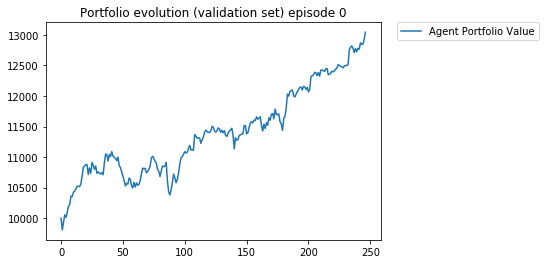

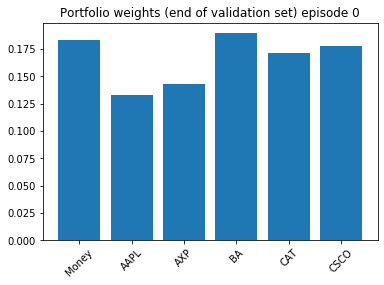

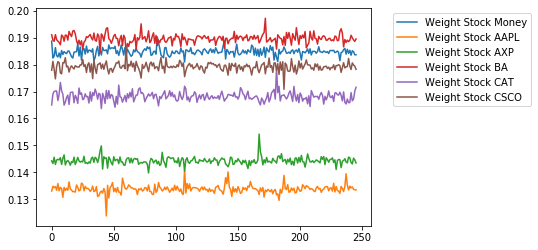

Episode: 1
End of test PF value: 13099.0
Min of test PF value: 9805.0
Max of test PF value: 13099.0
Mean of test PF value: 11401.0
End of test weights: [0.16701075 0.15476861 0.15362525 0.18010588 0.16096214 0.18352738]


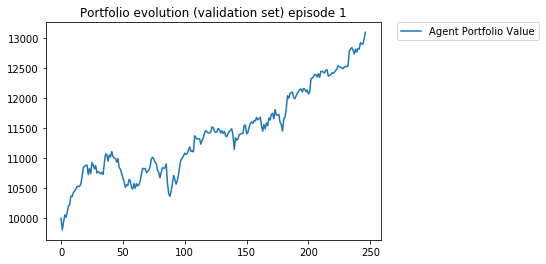

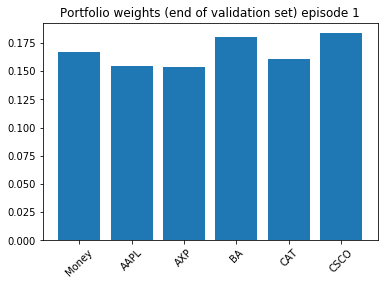

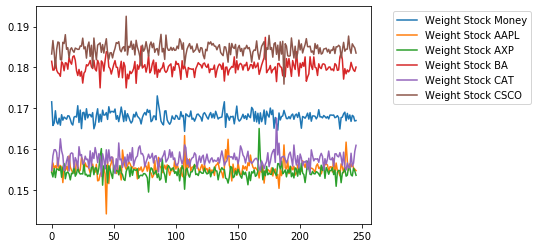

Episode: 2
End of test PF value: 13089.0
Min of test PF value: 9809.0
Max of test PF value: 13089.0
Mean of test PF value: 11370.0
End of test weights: [0.17313699 0.18563612 0.16988685 0.16915804 0.1347893  0.1673927 ]


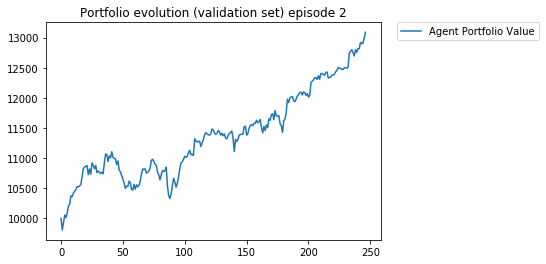

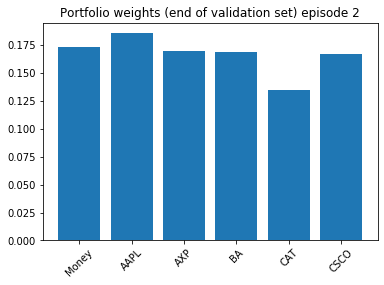

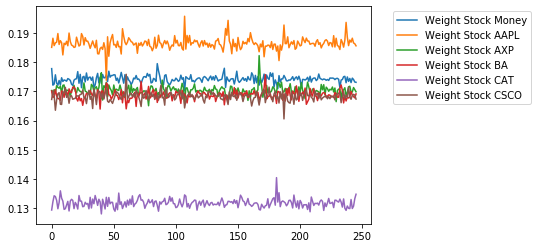

In [11]:
## Initialize variables
# Initialize weight vectors
w_init_train = np.array(np.array([1]+[0]*m))    
w_init_test = np.array(np.array([1]+[0]*m))    
w_eq = np.array(np.array([1/(m+1)]*(m+1)))
w_s = np.array(np.array([1]+[0.0]*m))

# Initialize session
tf.reset_default_graph()
sess = tf.Session()

# Initialize network / policy function
actor = Policy(m, tensor_history, sess, optimizer,                                   
                 trading_cost=trading_cost, 
                 interest_rate=interest_rate)  

# Initialize tensorflow graphs
sess.run(tf.global_variables_initializer())

# Initialize lists to store results
list_final_pf = list()
list_final_pf_eq = list()
list_final_pf_s = list()
list_final_pf_fu = list()
list_final_pf_fu = [list() for i in range(m)]
state_fu = [0]*m
done_fu = [0]*m
pf_value_t_fu = [0]*m

    
###### Train #####
for e in range(n_episodes):
    # if e==0: eval_perf('Before Training')
    print('Episode:', e)
    #init the PVM with the training parameters
    memory = PVM(m,sample_bias, total_steps = total_steps_train, 
                 batch_size = batch_size, w_init = w_init_train)
    
    for nb in range(n_batches):
        # print('Batch:',nb)
        #draw the starting point of the batch 
        i_start = memory.draw()
        
        #reset the environment with the weight from PVM at the starting point
        #reset also with a portfolio value with initial portfolio value
        state, done = env.reset(memory.get_W(i_start), pf_init_train, t=i_start )
        state_eq, done_eq = env_eq.reset(w_eq, pf_init_train, t=i_start )
        state_s, done_s = env_s.reset(w_s, pf_init_train, t=i_start )
        for i in range(m): state_fu[i], done_fu[i] = env_fu[i].reset(action_fu[i], pf_init_train, t=i_start )
        
        list_X_t, list_W_previous, list_pf_value_previous, list_dailyReturn_t = [], [], [], []
        list_pf_value_previous_eq, list_pf_value_previous_s = [],[]
        list_pf_value_previous_fu = list()
        for i in range(m): list_pf_value_previous_fu.append(list())
        
        for bs in range(batch_size):
            
            #load the different inputs from the previous loaded state 
            X_t = state[0].reshape([-1] + list(state[0].shape))
            W_previous = state[1].reshape([-1] + list(state[1].shape))
            pf_value_previous = state[2]
            
            
            if np.random.rand()< ratio_greedy:
                #print('go')
                #computation of the action of the agent
                action = actor.compute_W(X_t, W_previous)
            else:
                action = get_random_action(m)
            
            #given the state and the action, call the environment to go one time step later 
            state, reward, done = env.step(action)
            state_eq, reward_eq, done_eq = env_eq.step(w_eq)
            state_s, reward_s, done_s = env_s.step(w_s)
            
            for i in range(m):
                state_fu[i], _ , done_fu[i] = env_fu[i].step(action_fu[i])

            
            
            #get the new state 
            X_next = state[0]
            W_t = state[1]
            pf_value_t = state[2]
            pf_value_t_eq = state_eq[2]
            pf_value_t_s = state_s[2]
            for i in range(m): pf_value_t_fu[i] = state_fu[i][2]
                
            
            #let us compute the returns 
            dailyReturn_t = X_next[-1, :, -1]
            #update into the PVM
            memory.update(i_start+bs, W_t)
            #store elements
            list_X_t.append(X_t.reshape(state[0].shape))
            list_W_previous.append(W_previous.reshape(state[1].shape))
            list_pf_value_previous.append([pf_value_previous])
            list_dailyReturn_t.append(dailyReturn_t)
            
            list_pf_value_previous_eq.append(pf_value_t_eq)
            list_pf_value_previous_s.append(pf_value_t_s)
            for i in range(m): list_pf_value_previous_fu[i].append(pf_value_t_fu[i])
            
            if bs==batch_size-1:
                list_final_pf.append(pf_value_t)
                list_final_pf_eq.append(pf_value_t_eq)
                list_final_pf_s.append(pf_value_t_s)
                for i in range(m):
                    list_final_pf_fu[i].append(pf_value_t_fu[i])
            
            #printing
            #if bs==0:
            #    print('start', i_start)
            #    print('PF_start', round(pf_value_previous,0))
            #
            #if bs==batch_size-1:
            #    print('PF_end', round(pf_value_t,0))
            #    print('weight', W_t)

        list_X_t = np.array(list_X_t)
        list_W_previous = np.array(list_W_previous)
        list_pf_value_previous = np.array(list_pf_value_previous)
        list_dailyReturn_t = np.array(list_dailyReturn_t)
        
        
        #for each batch, train the network to maximize the reward
        actor.train(list_X_t, list_W_previous,
                    list_pf_value_previous, list_dailyReturn_t)
    eval_perf(e)

### Testing

In [0]:
####### Test #######

# Initialization of the environment 
state, done = env.reset(w_init_test, pf_init_test, t = total_steps_train)
state_eq, done_eq = env_eq.reset(w_eq, pf_init_test, t = total_steps_train)
state_s, done_s = env_s.reset(w_s, pf_init_test, t = total_steps_train)
for i in range(m): state_fu[i],  done_fu[i] = env_fu[i].reset(action_fu[i], pf_init_test, t = total_steps_train)

p_list = [pf_init_test]
w_list = [w_init_test]
p_list_eq = [pf_init_test]
p_list_s = [pf_init_test]
p_list_fu = list()
for i in range(m): p_list_fu.append([pf_init_test])
pf_value_t_fu = [0]*m

for k in range(total_steps_train +total_steps_val-int(tensor_history/2), total_steps_train +total_steps_val +total_steps_test -tensor_history):
    X_t = state[0].reshape([-1]+ list(state[0].shape))
    W_previous = state[1].reshape([-1]+ list(state[1].shape))
    pf_value_previous = state[2]

    action = actor.compute_W(X_t, W_previous)                                   # compute the action 

    state, reward, done = env.step(action)                                      # step forward environment 
    state_eq, reward_eq, done_eq = env_eq.step(w_eq)
    state_s, reward_s, done_s = env_s.step(w_s)
    for i in range(m): state_fu[i], _ , done_fu[i] = env_fu[i].step(action_fu[i])
    
    X_next = state[0]
    W_t = state[1]
    pf_value_t = state[2]
    pf_value_t_eq = state_eq[2]
    pf_value_t_s = state_s[2]
    for i in range(m): pf_value_t_fu[i] = state_fu[i][2]
    
    dailyReturn_t = X_next[-1, :, -1]

    p_list.append(pf_value_t)
    w_list.append(W_t)
    p_list_eq.append(pf_value_t_eq)
    p_list_s.append(pf_value_t_s)
    for i in range(m): p_list_fu[i].append(pf_value_t_fu[i])
        
    if k== total_steps_train +total_steps_val-int(tensor_history/2) + 100:
        break
    

### Analysis

Altough we haven't been able to reproduce the paper's results, nor find optimal hyperparameters for the individual problems due to the computational constraints. The algorithm has the capacity to identify high-potential stocks wich maximizes results if one takes the argmax of the softmax output. However, it has a little potential to change the position through the trading process. Morover, as can be seen below, it closely replicates the equiweighted portfolio. The reasion behind this is due to the reward function we chose. The reward corresponds to the porftfolio return minut the equiweighted portfolio return. Since in general the equiweighted portfolio preforms adequately well, in the short amount of epochs we are able to run the network it's only able to imitate the baseline. We have tried many initial parameters such as low trading cost to produce incentive to change of position or changes to the learning rate, but all attempts were unsuccesful. Our conclusion is that altough the agent is 'training sensitive' its behaviour is more or less similar across different data and inputs and thefore its not 'input state sensitive'. Additional sensitivity analysis we belive is out of scope of this project. 

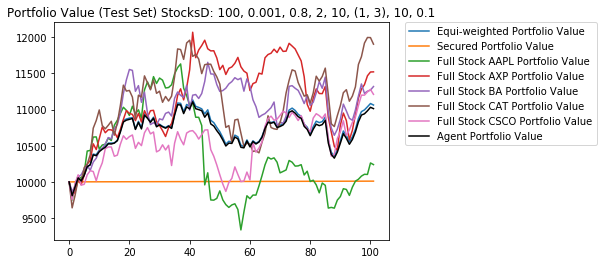

In [13]:
plt.title('Portfolio Value (Test Set) {}: {}, {}, {}, {}, {}, {}, {}, {}'.format(data_dir, batch_size, learning_rate, ratio_greedy, e, tensor_history, kernel1_size, n_batches, ratio_regul))
plt.plot(p_list_eq, label = 'Equi-weighted Portfolio Value')
plt.plot(p_list_s, label = 'Secured Portfolio Value')
for i in range(m):
    plt.plot(p_list_fu[i], label = 'Full Stock {} Portfolio Value'.format(list_stock[i]))
plt.plot(p_list, label = 'Agent Portfolio Value', color = 'black')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

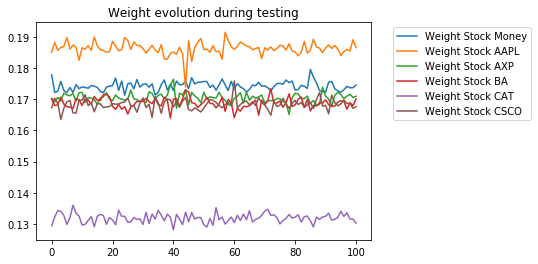

In [14]:
names = ['Money'] + list_stock
w_list = np.array(w_list)
for j in range(m+1):
    plt.plot(w_list[1:,j], label = 'Weight Stock {}'.format(names[j]))
    plt.title('Weight evolution during testing')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.show()